<a href="https://colab.research.google.com/github/abdoulsn/NLP-Tweets-Disaster/blob/master/Feature%20Engineering_and_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Disaster Tweets EDA

This notebook contains basic and/or complicated EDA.

In [27]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
!pip install -q wordcloud
import wordcloud
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')



from nltk.util import ngrams
from collections import defaultdict
from collections import Counter
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
# from spellchecker import SpellChecker

# set color codes
sns.set_color_codes('pastel')
plt.style.use('ggplot')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Loading the dataset from [EnesGokce](https://raw.githubusercontent.com/EnesGokceDS/)  Repo (He was in my team)


In [0]:
url1= 'https://raw.githubusercontent.com/EnesGokceDS/NLP_team_project/master/text_cleaned.csv' # With text_cleaned data
url2='https://raw.githubusercontent.com/EnesGokceDS/NLP_team_project/master/text__testdata_cleaned.csv'
url3= 'https://raw.githubusercontent.com/farmani60/NLP-Tweets-Disaster/master/data/sample_submission.csv'
train = pd.read_csv(url1)
test = pd.read_csv(url2)
sample_submission = pd.read_csv(url3)

In [29]:
print('Number of samples in train set: {}'.format(train.shape[0]))
print('Number of samples in test set: {}'.format(test.shape[0]))

Number of samples in train set: 7552
Number of samples in test set: 3237


In [30]:
train.sample(5).round(2)

,id,keyword,text,target,stopwords,punctuation,hastags,numerics,upper,word_count,char_count,avg_word
822,1235,blood,stars reviewers dragon blood boxset lindsay...,0,5,14,1,2,0,13,80,7.56
2330,3397,demolition,seven chinese christians detained amid widespr...,1,0,5,0,0,0,10,73,7.11
4373,6261,hijacking,hot funtenna hijacking computers send data sou...,0,2,11,3,0,0,14,80,5.58
5611,8045,refugees,newlyweds feed thousands syrian refugees inste...,1,3,7,0,0,0,13,88,6.33
7215,10376,weapons,liked youtube video dannyonpc battlefield har...,0,2,11,0,1,3,13,87,6.82


### Distribution of the Target

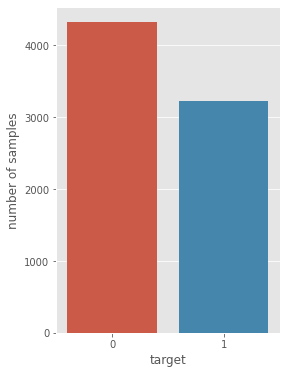

In [31]:
df = train.groupby(['target'])['id'].count()
df = df.reset_index()
df = df.rename(columns={'id': 'number of samples'})
fig, ax = plt.subplots(figsize=(4, 6))

sns.barplot(x='target', y='number of samples', data=df)

So, the classes are kind of balanced but we have about 1000 more samples in no disaster tweets.

In [32]:
print('Number of disaster tweets: {}'.format(df.loc[df['target']==1]['number of samples'].values[0]))
print('Number of no disaster tweets: {}'.format(df.loc[df['target']==0]['number of samples'].values[0]))

Number of disaster tweets: 3229
Number of no disaster tweets: 4323


In [33]:
train.loc[train.text.isnull()]

,id,keyword,text,target,stopwords,punctuation,hastags,numerics,upper,word_count,char_count,avg_word
5084,7295,nuclear%20reactor,NaN,0,0,1,0,0,0,1,0,0.0


In [34]:
train= train.dropna()
train.loc[train.text.isnull()]

,id,keyword,text,target,stopwords,punctuation,hastags,numerics,upper,word_count,char_count,avg_word


### Number of Characters in Tweets

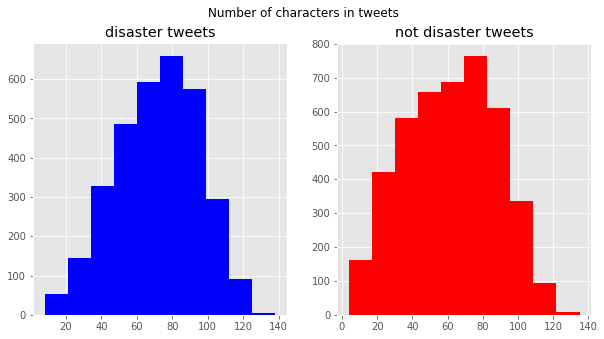

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

tweet_len = train.loc[train['target']==1]['text'].str.len()
ax1.hist(tweet_len, color='blue')
ax1.set_title('disaster tweets')
tweet_len = train.loc[train['target']==0]['text'].str.len()
ax2.hist(tweet_len, color='red')
ax2.set_title('not disaster tweets')

fig.suptitle('Number of characters in tweets')

plt.show()

Both diaster and not disaster tweets have almost same distribution on number of characters. 70 to 90 characters are most common in both groups.

### Number of Words in Tweets

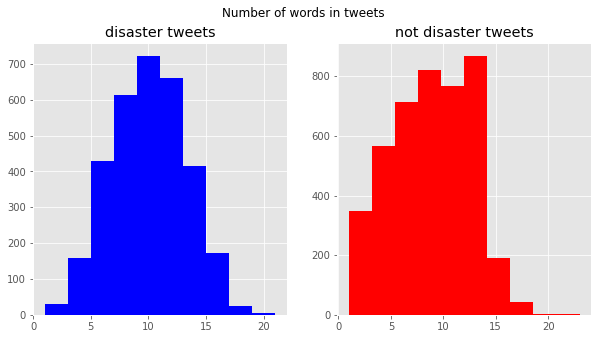

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
tweet_len = train.loc[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len, color='blue')
ax1.set_title('disaster tweets')

tweet_len = train.loc[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len, color='red')
ax2.set_title('not disaster tweets')

fig.suptitle('Number of words in tweets')

plt.show()

It seems not disaster tweets have slightly more words. This might be used as a feature!

### Average Word Length in Tweets

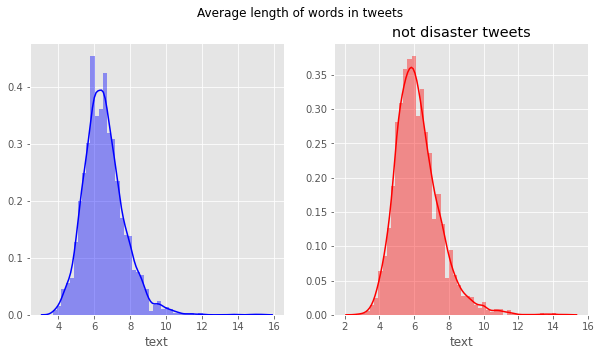

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

words = train.loc[train['target']==1] ['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(words.map(lambda x: np.mean(x)), ax=ax1, color='blue')


words = train.loc[train['target']==0] ['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(words.map(lambda x: np.mean(x)), ax=ax2, color='red')
ax2.set_title('not disaster tweets')

fig.suptitle('Average length of words in tweets')

plt.show()

Disaster and not disaster have almost same distribution over average length of words in them.

In [0]:
# funcion to make corpus
def make_corpus(df, target):
    corpus = []
    for x in df.loc[df['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

### Stop Words

In [0]:
# make a corpus of not disaster tweets
not_disaster_corpus = make_corpus(train, target=0) # stop words for not disaster tweets
dic = defaultdict(int)

for word in not_disaster_corpus:
    if word in stop_words:
        dic[word] += 1
        
# top 10 stop words in not disaster tweets
not_disaster_top_stop_words = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]

# make a corpus of disaster tweets
disaster_corpus = make_corpus(train, target=1) # stop words for disaster tweets
dic = defaultdict(int)

for word in disaster_corpus:
    if word in stop_words:
        dic[word] += 1
        
# top 10 stop words in disaster tweets
disaster_top_stop_words = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]

In [40]:
print(disaster_top_stop_words)

[]


In [41]:
#This part can be added to data cleaning section before cleaning stopwords

'''
x1, y1 = zip(*disaster_top_stop_words)
x2, y2 = zip(*not_disaster_top_stop_words)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.bar(x1, y1, color='blue')
ax1.set_title('disaster tweets')

ax2.bar(x2, y2, color='red')
ax2.set_title('not disaster tweets')

fig.suptitle('Top 10 stop words')

plt.show()
'''

"\nx1, y1 = zip(*disaster_top_stop_words)\nx2, y2 = zip(*not_disaster_top_stop_words)\n\nfig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))\n\nax1.bar(x1, y1, color='blue')\nax1.set_title('disaster tweets')\n\nax2.bar(x2, y2, color='red')\nax2.set_title('not disaster tweets')\n\nfig.suptitle('Top 10 stop words')\n\nplt.show()\n"

In both classes `the` is the most frequent stop word followed by `a` in class not disaster and `in` in class disaster.

### Punctuations

In [0]:
punctuations = string.punctuation

dic_punc_not_disaster = defaultdict(int)

for word in not_disaster_corpus:
    if word in punctuations:
        dic_punc_not_disaster[word] += 1
        
dic_punc_disaster = defaultdict(int)

for word in disaster_corpus:
    if word in punctuations:
        dic_punc_disaster[word] += 1



In [43]:
#print('Number of disaster tweets: {}'.format(train.loc[train['target']==1]['text']))
tweet_len = train.loc[train['target']==1]['text'].str.len()
print(tweet_len)

0        32
2        53
6        28
7       103
15       56
       ... 
7511     67
7512     68
7521     31
7528     35
7541     31
Name: text, Length: 3229, dtype: int64


In [44]:

#df_train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
tweet_punc = train.loc[train['target']==1]['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
print(tweet_punc)
ax1.hist(tweet_punc, color='blue')
ax1.set_title('disaster tweets')

tweet_punc = train.loc[train['target']==0]['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
ax2.hist(tweet_punc, color='red')
ax2.set_title('not disaster tweets')

fig.suptitle('Number of punctuation in tweets')

plt.show()

0       0
2       0
6       0
7       0
15      0
       ..
7511    0
7512    0
7521    0
7528    0
7541    0
Name: text, Length: 3229, dtype: int64


### Common Words

In [0]:
disaster_counter = Counter(disaster_corpus)
disaster_most_common_words = disaster_counter.most_common()

x1 = []
y1 = []

for word, count in disaster_most_common_words[:40]:
    if (word not in stop_words) & (word not in punctuations):
        x1.append(word)
        y1.append(count)
        
not_disaster_counter = Counter(not_disaster_corpus)
not_disaster_most_common_words = not_disaster_counter.most_common()

x2 = []
y2 = []

for word, count in not_disaster_most_common_words[:40]:
    if (word not in stop_words) & (word not in punctuations):
        x2.append(word)
        y2.append(count)

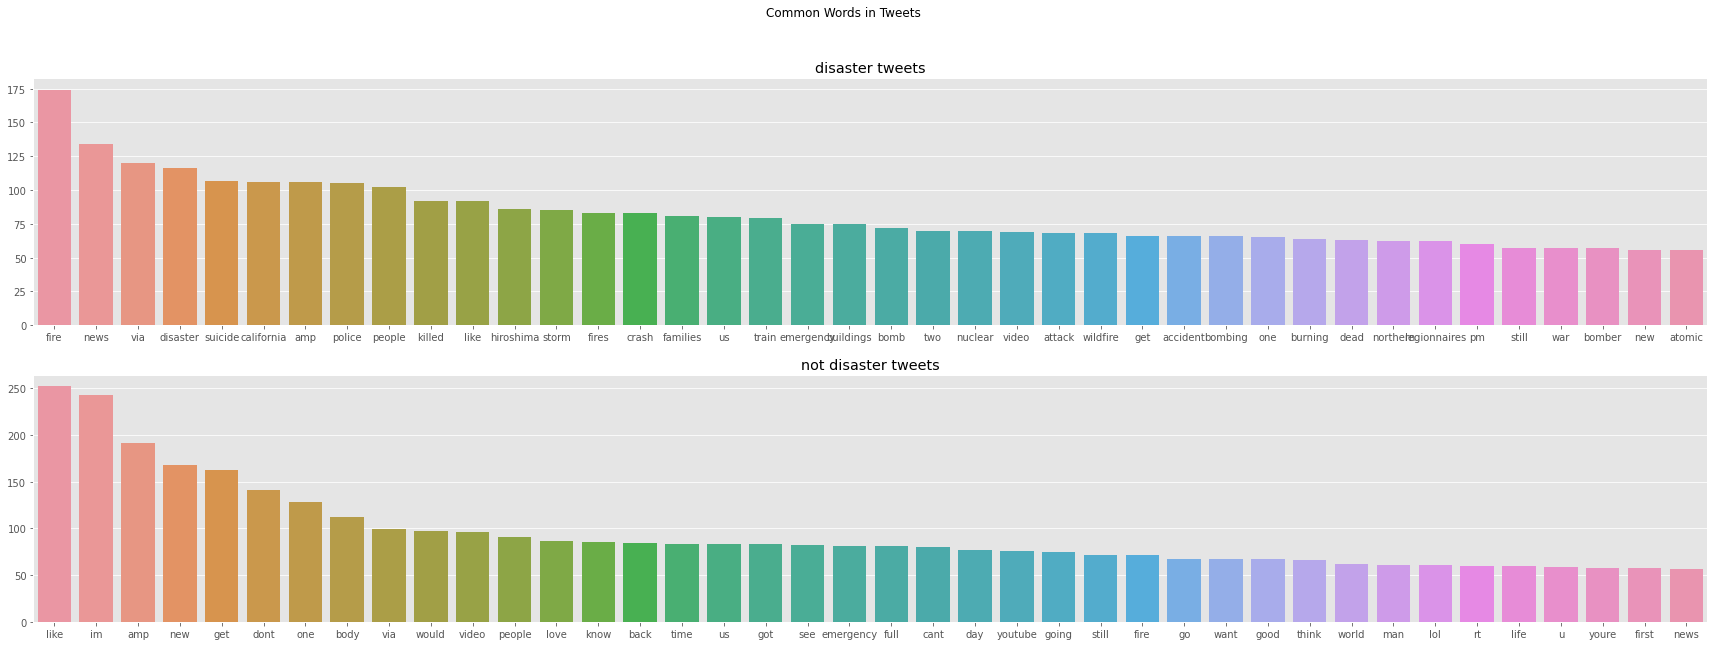

In [46]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 10))

sns.barplot(x1, y1, ax=ax1)
ax1.set_title('disaster tweets')

sns.barplot(x2, y2, ax=ax2)
ax2.set_title('not disaster tweets')

fig.suptitle('Common Words in Tweets')
plt.show()

Lots of cleaning needed!

### Ngram Analysis

We analyze bigrams (n = 2) and trigrams (n = 3) over tweets. Let's check the most common ngrams in tweets. 

In [0]:
def get_top_tweet_ngrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq

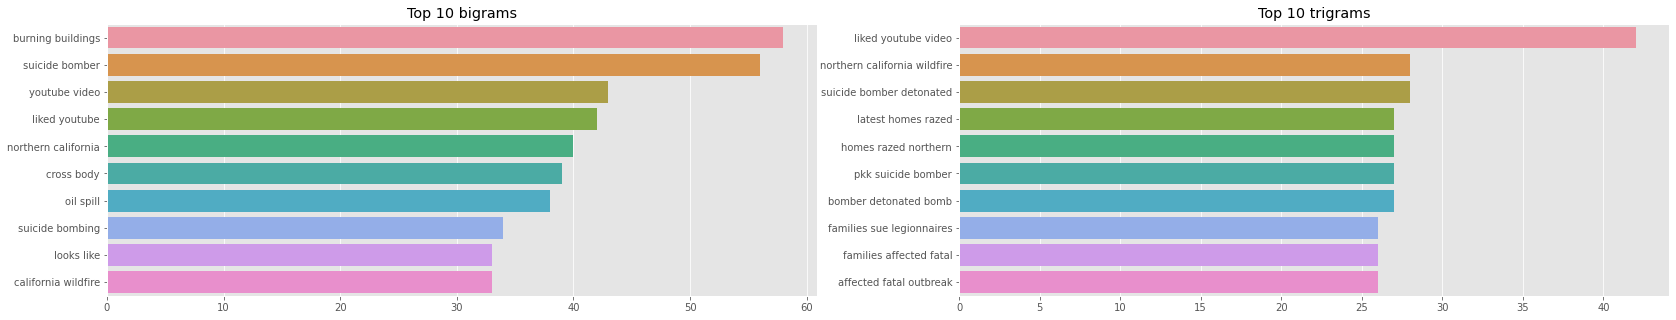

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(28, 5))

top_tweet_bigrams = get_top_tweet_ngrams(train['text'], n=2)[:10]
top_tweet_trigrams = get_top_tweet_ngrams(train['text'], n=3)[:10]

x1, y1 = map(list, zip(*top_tweet_bigrams))
x2, y2 = map(list, zip(*top_tweet_trigrams))

sns.barplot(y1, x1, ax=ax1)
sns.barplot(y2, x2, ax=ax2)
ax1.set_title('Top 10 bigrams')
ax2.set_title('Top 10 trigrams')

plt.show()

A lot of cleaning is needed here too!

### Data Cleaning

* Spelling Correction
* Removing Punctuations
* Removing html tags
* Removing Emojis

In [49]:
#df = pd.concat([train, test])
df= train 
df.head()

,id,keyword,text,target,stopwords,punctuation,hastags,numerics,upper,word_count,char_count,avg_word
0,48,ablaze,bbcmtd wholesale markets ablaze,1,0,6,0,0,0,5,32,6.999998
1,49,ablaze,always try bring heavy metal rt,0,2,8,2,0,1,7,32,4.333333
2,50,ablaze,africanbaze breaking newsnigeria flag set abla...,1,1,9,1,0,1,8,53,6.571428
3,52,ablaze,crying set ablaze,0,3,1,0,0,0,3,17,4.999998
4,53,ablaze,plus side look sky last night ablaze,0,0,5,0,0,9,8,37,4.285714


### Removing urls

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7551 entries, 0 to 7551
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           7551 non-null   int64  
 1   keyword      7551 non-null   object 
 2   text         7551 non-null   object 
 3   target       7551 non-null   int64  
 4   stopwords    7551 non-null   int64  
 5   punctuation  7551 non-null   int64  
 6   hastags      7551 non-null   int64  
 7   numerics     7551 non-null   int64  
 8   upper        7551 non-null   int64  
 9   word_count   7551 non-null   int64  
 10  char_count   7551 non-null   int64  
 11  avg_word     7551 non-null   float64
dtypes: float64(1), int64(9), object(2)
memory usage: 766.9+ KB


In [0]:
df['text'] = df['text'].astype(str)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7551 entries, 0 to 7551
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           7551 non-null   int64  
 1   keyword      7551 non-null   object 
 2   text         7551 non-null   object 
 3   target       7551 non-null   int64  
 4   stopwords    7551 non-null   int64  
 5   punctuation  7551 non-null   int64  
 6   hastags      7551 non-null   int64  
 7   numerics     7551 non-null   int64  
 8   upper        7551 non-null   int64  
 9   word_count   7551 non-null   int64  
 10  char_count   7551 non-null   int64  
 11  avg_word     7551 non-null   float64
dtypes: float64(1), int64(9), object(2)
memory usage: 766.9+ KB


In [0]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

In [54]:
df.sample()

,id,keyword,text,target,stopwords,punctuation,hastags,numerics,upper,word_count,char_count,avg_word
3155,4575,emergency%20plan,bc costs less sick people using emergency room...,1,3,14,0,0,0,9,70,6.888888


In [0]:
# remove all urls from df
df['text'] = df['text'].apply(lambda x: remove_url(x))

### Removing HTML Tags

In [0]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [0]:
# remove all html tags from df
df['text'] = df['text'].apply(lambda x: remove_html(x))

 ### Removing Emojis
 
 Emojis can be indactors of some emotionals that can be related to being disaster or not. So, later we should decide if we want to remove them from tweets or not.

In [0]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [59]:
remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [0]:
# remove all emojis from df
df['text'] = df['text'].apply(lambda x: remove_emoji(x))

### Removing Punctuations

In [61]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

example="I am a #king"
print(remove_punct(example))

I am a king


In [0]:
# remove all punctuations from df
df['text'] = df['text'].apply(lambda x: remove_punct(x))

### Spelling Correction

Couldn't install spellchecker package on kaggle teminal!

In [0]:
# from spellchecker import SpellChecker

# spell = SpellChecker()
# def correct_spellings(text):
#     corrected_text = []
#     misspelled_words = spell.unknown(text.split())
#     for word in text.split():
#         if word in misspelled_words:
#             corrected_text.append(spell.correction(word))
#         else:
#             corrected_text.append(word)
#     return " ".join(corrected_text)
        
# text = "corect me plese"
# correct_spellings(text)

In [0]:
# df['text'] = df['text'].apply(lambda x : correct_spellings(x))

### Glove for Vectorization

Loot at what this is and try to utulize

In [0]:
def create_corpus(df):
    corpus = []
    for tweet in tqdm(df['text']):
        words = [word.lower() for word in word_tokenize(tweet) if ((word not in stop_words) & (word.isalpha()==1))]
        corpus.append(words)
    return corpus

In [66]:
corpus = create_corpus(df)

100%|██████████| 7551/7551 [00:00<00:00, 7952.98it/s]


In [67]:
! ls ../input/nlp-getting-started

ls: cannot access '../input/nlp-getting-started': No such file or directory


In [0]:
!wget http://nlp.stanford.edu/data/glove.6B.zip #We need to explore the usage of this

--2020-05-16 02:57:44--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-05-16 02:57:44--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-05-16 02:57:44--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [0]:
! ls

In [0]:
df.sample(5)

In [0]:
# Now, let's take a look at the punctuation number for tweets

plt.figure(figsize=(12,10), dpi= 100 )
# sns.set(font_scale=1)

with sns.axes_style('white'):
    g = sns.catplot( 'punctuation', data= df, aspect= 2, kind='count', 
                    hue='target', hue_order=df['target'].value_counts().sort_values(ascending=False).index)
    g.set_ylabels('Number of Tweets')
    g.set_xlabels('Number of Punction')
    g.set_titles('Distrubition of Number of Punction for Tweets')

Until number of punction is 5, no disaster tweets have has more number of tweets. In the other words,  no disaster tweets use less punction.


##### **Keep in mind:**  
    Number of disaster tweets: 3229
    Number of no disaster tweets: 4323

In [0]:
df.sample()

In [0]:

import plotly.express as px
fig = px.histogram(df, x="char_count",color="target", marginal="rug",
                   title='Distiribtion of number of character',
                   labels={'char_count':'Distiribtion of number of character'})
fig.show()


In [0]:
df.groupby('word_count').numerics.agg(['sum','count']).plot(kind='area') # I need to figure out how to make this plot bigger

#This may not be a meaningful plot



In [0]:
df.groupby('word_count').numerics.agg(['sum','count'])

In [0]:
# Now, let's take a look at the pet species for each claim

plt.figure(figsize=(12,10), dpi= 100 )
# sns.set(font_scale=1)

with sns.axes_style('white'):
    g = sns.catplot( 'hastags', data= df, aspect= 2, kind='count', 
                    hue='target', hue_order=df['target'].value_counts().sort_values(ascending=False).index)
    g.set_ylabels('Number of Tweets')
    g.set_xlabels('Number of Hastag')
    g.set_titles('Distrubition of Number of Hastag for Tweets')

In [0]:

import plotly.express as px
fig = px.histogram(df, x="hastags",color="target", marginal="rug",
                   title='Distiribtion of number of character',
                   labels={'char_count':'Distiribtion of number of character'})
fig.show()
